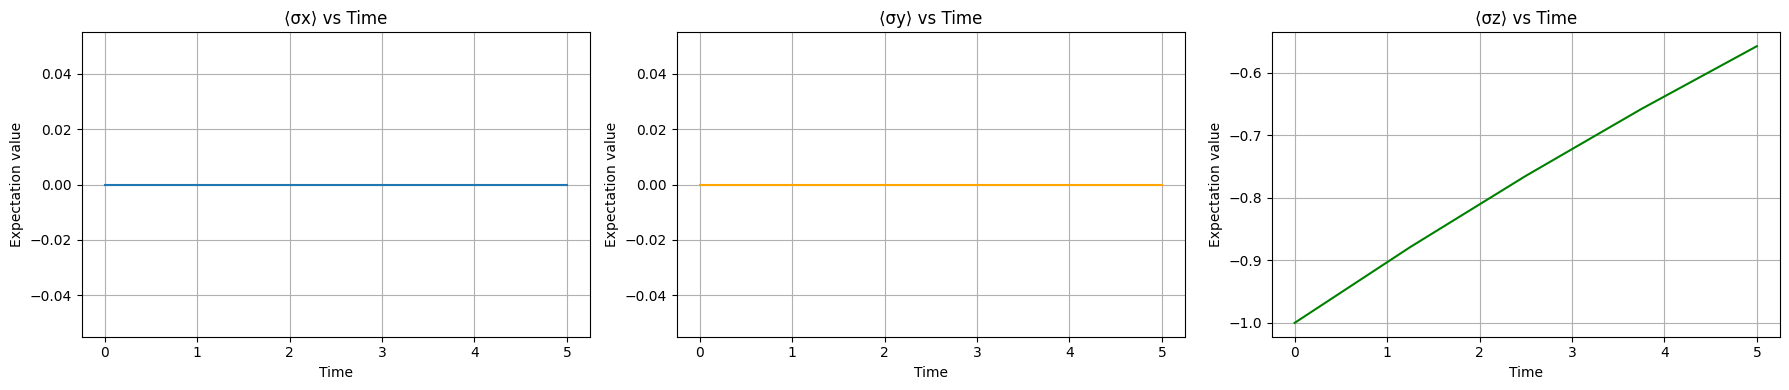

t = 0.00
Analytical rho_t:
 [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
QC simulated rho:
 [[ 0. -0.]
 [-0.  1.]] 

t = 1.25
Analytical rho_t:
 [[0.0606+0.j 0.    +0.j]
 [0.    +0.j 0.9394+0.j]]
QC simulated rho:
 [[0.0606 0.    ]
 [0.     0.9394]] 

t = 2.50
Analytical rho_t:
 [[0.1175+0.j 0.    +0.j]
 [0.    +0.j 0.8825+0.j]]
QC simulated rho:
 [[0.1175 0.    ]
 [0.     0.8825]] 

t = 3.75
Analytical rho_t:
 [[0.171+0.j 0.   +0.j]
 [0.   +0.j 0.829+0.j]]
QC simulated rho:
 [[0.171 0.   ]
 [0.    0.829]] 

t = 5.00
Analytical rho_t:
 [[0.2212+0.j 0.    +0.j]
 [0.    +0.j 0.7788+0.j]]
QC simulated rho:
 [[0.2212 0.    ]
 [0.     0.7788]] 



In [ ]:
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
from scipy.linalg import expm
from qutip import destroy, sigmaz, liouvillian, Qobj
from numpy.linalg import eig
from qutip import to_choi
import matplotlib.pyplot as plt
from qutip import *
#γ(t)→γ0​

# S(t)→γ0λ/λ+d    S(t)→λ+dγ0​λ​

gamma0 = 0.5      
S0     = 0.0     


sp   = sigmap()           
# sp    = sm.dag()              
H_LS  = Qobj(np.zeros((2,2)))   

exp_vals_x =[]
exp_vals_y =[]
exp_vals_z =[]

c_ops = [ np.sqrt(gamma0) * sp ]

L     = liouvillian(H_LS, c_ops)


def choi_to_kraus(choi: Qobj, tol: float=1e-9):
    vals, vecs = eig(choi.full())
    d = 2
    kraus = []
    for val, vec in zip(vals, vecs.T):
        if val > tol:
            mat = vec.reshape((d, d), order='F')
            kraus.append(np.sqrt(val) * mat)
    return kraus

def SVD(K):
    U, s, Vh = svd(K)
    sigma = np.diag(s)
  
    theta = np.arccos(np.clip(s, -1, 1))
    phases = np.concatenate([theta, -theta])
    U_sigma = np.diag(np.exp(1j * phases))
    return U, U_sigma, Vh

def Quantum_circuit(U, sigma, V):
    qc = QuantumCircuit(2)
    qc.x(0)
    qc.append(UnitaryGate(V), [0])
    qc.h(1)
    qc.append(UnitaryGate(sigma), [0,1])
    qc.append(UnitaryGate(U), [0])
    qc.h(1)
    qc.save_statevector()
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc, shots=1).result()
    sv = result.get_statevector(qc)

    
    psi =[]
    for i in range(2):
        psi.append(sv[i])
    qc.draw('mpl')  
    return np.outer(psi, np.conj(psi))
times = np.linspace(0, 5, 5)
results = []
for t in times:
    superprop = (t * L).expm()
    choi      = to_choi(superprop)
    kraus_ops = choi_to_kraus(choi)
    rho_t = np.zeros((2,2), dtype=complex)
    for K in kraus_ops:
        rho_t += K @ np.array([[0,0],[0,1]]) @ K.conj().T
    
    # unitary dilation
    rho_sim = np.zeros((2,2), dtype=complex)
    for K in kraus_ops:
        U, sigma, V = SVD(K)
        rho_sim  += Quantum_circuit(U, sigma, V)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    exp_vals_x.append(np.round((np.real(np.trace(rho_sim @ sigma_x))),8))
    exp_vals_y.append(np.round((np.real(np.trace(rho_sim @ sigma_y))),8))
    exp_vals_z.append(np.real(np.trace(np.dot(rho_sim, sigma_z))))
    
    
    results.append((rho_t, rho_sim.real))
    

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    
axes[0].plot(times,np.round(exp_vals_x,8), label="⟨σx⟩")
axes[0].set_title("⟨σx⟩ vs Time")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Expectation value")
axes[0].grid(True)

axes[1].plot(times, exp_vals_y, label="⟨σy⟩", color='orange')
axes[1].set_title("⟨σy⟩ vs Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Expectation value")
axes[1].grid(True)

axes[2].plot(times, exp_vals_z, label="⟨σz⟩", color='green')
axes[2].set_title("⟨σz⟩ vs Time")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Expectation value")
axes[2].grid(True)

plt.tight_layout()
plt.show()



# Display comparison for each time
for idx, t in enumerate(times):
    print(f"t = {t:.2f}")
    print("Analytical rho_t:\n", np.round(results[idx][0],4))
    print("QC simulated rho:\n", np.round(results[idx][1],4), "\n")

# Display the quantum circuit